各ピクセルに対して[黒、白]の黒となる確率μiを考える


データ行列X[画像の枚数, 1枚の画像の全ピクセル]

黒x_i = 1 : pi = μi

白xi = 0 : pi = (1 - μi)

あるピクセルが黒になる確率 pi = μi^x_i * (1 - μi)^(1 - x_i)

Dピクセルの1枚の画像の生成確率 p(x) = Πi:1_D[ pi ] = Πi:1_D[ μi^x_i * (1 - μi)^(1 - x_i) ] ・・・(1)

トレーニングセットN枚の画像の生成確率(尤度関数) P = Πn:1_N = Πn:1_NΠn:1_D [ p(x) ]

対数尤度関数log(P) = Σn:1_NΣi:1_D [ [x_n]_i * log(μi) + (1 - [x_n]_i) * log(1 - μi) ]

μiで偏微分して、

d(log(P))/dμi = Σn:1_N [ [x_n]_i / μi - (1 - [x_n]_i) / (1 - μi) ] = 0

μi = Σn:1_N [x_n]i / N

全部でK種類の画像生成器{μk}k:1_K (1)がK種類

Pμk(x) = Πi:1_D [ [μk]_i^xi * (1 - [μk]_i^(1 - xi)) ]

K種類の画像生成器の中から1つを選択する確率Πk, Σk:1_K [ Πk ] = 1

画像生成器Kによって特定の画像Xが得られる確率 P(x) = Σk:1_K [ Πk * Pμk(x) ]

トレーニングセット全体が得られる確率

P = Πn:1_N [ p(x_n) ] = Πn:1_NΣk:1_K [ Πk * Pμk(x_n) ]

P =  Πn:1_NΣk:1_K [ Πk * Πi:1_D [ [μk]_i^xi * (1 - [μk]_i^(1 - xi)) ] ] 

# EMアルゴリズム

In [9]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.misc import logsumexp
%matplotlib inline

In [10]:
# mnistの読み込み

def load_mnist(path, kind='train'):
    """MNISTをロード"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [11]:
X_train, y_train = load_mnist('./data/mnist', kind='train')
#print(X_train[:5])

In [12]:
# 画像データの2値化
def binarize_img(X):
    N = X.shape[0]
    D = X.shape[1]
    
    for i in range(N):
        for k in range(D):
            if X[i, k] > 127:
                X[i, k] = 1
            else:
                X[i, k] = 0
    
    return X

In [13]:
def bernoulli(x, p):
    """
    多変量ベルヌーイ関数(変数の数は画像ピクセル数)
    """
    bernoulli = 1
    epsilon = 1e-5
    D = len(x)
    
    # 確率のクリップ
    np.clip(p, 1e-10, (1 - 1e-10), out=p)

    for x_i, pk_i in zip(x, p):
        #bernoulli *= (p[i] ** x[i]) * (1 - p[i]) ** (1 - x[i])
        if x_i == 1:
            bernoulli *= pk_i
        else:
            bernoulli *= (1 - pk_i)
            
        # ゼロ回避
            
    return bernoulli #+ epsilon

In [14]:
"""
X = binarize_img(X_train[:1])
p = np.random.rand(K, D) # ピクセルの生成確率
print(X[0])
print(p[0])

print(bernoulli(X[0], p[0]))
"""

'\nX = binarize_img(X_train[:1])\np = np.random.rand(K, D) # ピクセルの生成確率\nprint(X[0])\nprint(p[0])\n\nprint(bernoulli(X[0], p[0]))\n'

In [22]:
def berLogLikelihood(X, p):
    """
    対数尤度関数
    """
    D = len(X)
    #likelihood = 0.0
    log_likelihood = 0.0
    
    
    """
    # 以下のやり方だと、0以下の確率を何度も掛け算して、
    # bernoulli(X[i], p[k])が0に限りなく近くなり、lilelihoodも0近くなり,
    # 結果, np.log(likelihood) → -∞　になってしまう。
    
    for i in range(N):
        for k in range(K):
            ber = 1.0
            for j in range(D):
                ber *= bernoulli(X[i][j], p[k][j]) # ここでberがほとんど0になってしまう
            Kber = pi[k] * ber
            likelihood += Kber
            print("likelihood\n", likelihood)
            
        log_likelihood += np.log(likelihood)
    """
    
    # 上記の問題を回避するコード
    np.clip(p, 1e-10, (1 - 1e-10), out=p) # 確率のクリップ
    
    for j in range(D):
        pj = p[j]
        log_likelihood += X[j] * np.log(pj) + (1 - X[j]) * np.log(1 - pj)
    
    return log_likelihood

In [23]:
def show_images(mu):
    fig = plt.figure(figsize=(12, 10))
    K = len(mu)
    for k in range(K):
        subplot = fig.add_subplot(1,K,k+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(mu[k].reshape(28,28), cmap=plt.cm.gray_r)

binal_X:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
p.shape: (9, 784)
p: [[0.04810406 0.40671285 0.56394584 ... 0.41367077 0.05032032 0.27024416]
 [0.03417712 0.22543121 0.7834113  ... 0.87147809 0.00694034 0.48771464]
 [0.77835721 0.90084067 0.33552209 ... 0.56436992 0.4399136  0.46665802]
 ...
 [0.85704154 0.67275052 0.25422462 ... 0.65077049 0.09712435 0.57693472]
 [0.07976731 0.92248424 0.97962027 ... 0.17852061 0.91106956 0.29294552]
 [0.56386194 0.47611268 0.80581463 ... 0.40714613 0.08628012 0.57082337]]
pi.shape: (9,)
pi:
 [0.36255251 0.67786492 0.18677287 0.93220438 0.62871941 0.60230943
 0.8165207  0.1803235  0.37268439]
gamma.shape: (10, 9)
-7892.875269221109
-7443.7469632454295
-8033.613146474644
-8083.045085513676
-7644.398519839752
-8075.806065830594
-7653.882619543291
-8026.8957208789125
-8185.583828104955
turn:0, logLike:-8185.583828104955


/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


gamma[:][k=1~9]:
 [[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
  0.11111111 0.11111111 0.11111111]
 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
  0.05555556 0.05555556 0.05555556]
 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
  0.03703704 0.03703704 0.03703704]
 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778]
 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
  0.02222222 0.02222222 0.02222222]
 [0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
  0.01851852 0.01851852 0.01851852]
 [0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
  0.01587302 0.01587302 0.01587302]
 [0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
  0.01388889 0.01388889 0.01388889]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01111111 0.01111111 0.01111111 0.01111111 

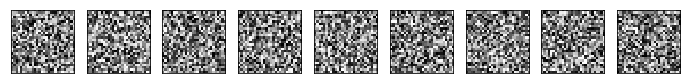

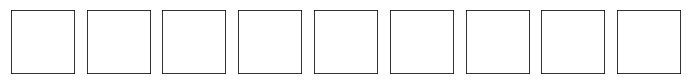

In [30]:
# メイン
X = binarize_img(X_train[:10])
print("binal_X:\n", X)

K = 9 # 混合モデルの数
N = X.shape[0] # サンプルサイズ
D = X.shape[1] # 1枚のピクセル数

p = np.random.rand(K, D) # ピクセルの生成確率
print("p.shape:", p.shape)
print("p:", p)

# 混合係数
pi = np.random.rand(K)
print("pi.shape:", pi.shape)
print("pi:\n", pi)

# 負担率の空配列を用意
gamma = np.zeros((N, K))
print("gamma.shape:", gamma.shape)
#print("gamma:\n", gamma[:3])


# 対数尤度の初期値
for k in range(K):
    logLike = 0.0
    for i in range(N):
        logLike += berLogLikelihood(X[i], p[k])
    print(logLike)

turn = 0
while True:
    print("turn:{0}, logLike:{1}".format(turn, logLike))
    
    # 成功確率の画像表示
    show_images(p)
    
    # Eステップ：負担率の計算
    denominator = 0.0
    for i in range(N):
        for k in range(K):
            logGamma_K = np.log(pi[k]) + berLogLikelihood(X[i], p[k])
            logGamma_K -= logsumexp(logGamma_K) # ここ重要
            gamma[i][k] = np.exp(logGamma_K) # 戻す
            denominator += gamma[i][k]
        
        # 各kの負担率
        for k in range(K):
            gamma[i][k] = gamma[i][k] / denominator
            
    print("gamma[:][k=1~9]:\n", gamma[:][:])
    
    # Mステップ：パラメタの再計算
    for k in range(K):
        
        # N_kを計算(分母)
        Nk = 0.0
        for i in range(N):
            Nk += gamma[i][k]
        print("Nk[=%d]:" % k, Nk)
        
        # 生成確率の再計算
        p[k] = np.zeros(D)
        for n in range(N):
            #print("X[%d] = " % n)
            #print(X[n])
            p[k] += gamma[n][k] * X[n]
        p[k] /= Nk
        #print("p[{0}]=\n{1}".format(k, p[k]))
        
        # 混合係数を再計算
        pi[k] = Nk / N
    
    
    # 収束判定
    new_logLike = 0.0
    for i in range(N):
        for k in range(K):
            new_logLike += berLogLikelihood(X[i], p[k])
    diff_logLike = new_logLike - logLike
    
    if diff_logLike < 0.01:
        print("new_logLike:%f, logLike:%f" % (new_logLike, logLike))
        break
    logLike = new_logLike
    turn += 1
